## Загрузим нужные библиотеки

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

from google.colab import drive, files
drive.mount('/content/drive')
!pip install catboost
from catboost import CatBoostClassifier

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Altai/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Altai/test.csv')

## Анализ важности признаков

По условию задачи есть имеются признаки, которые могут не представлять никакой значимости для модели. Сразу обучу модель catboost и оценю важность признаков для построения прогноза.

In [22]:
df_test = df_train.copy()

In [23]:
X = df_test.drop(["Статус",'ID'], axis = 1).fillna(0).astype('string').astype('category')
y = df_test[["Статус"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
mass_object = X.dtypes[X.dtypes == "category"].index.values

In [25]:
mass_object

array(['Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП',
       'Регион_ПП', 'Город_ПП', 'Общежитие', 'Наличие_Матери',
       'Наличие_Отца', 'Страна_Родители', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата'], dtype=object)

In [ ]:
model = CatBoostClassifier(loss_function='MultiClass')
model.fit(X_train, y_train, cat_features = mass_object)

In [27]:
pred = model.predict(X_test)
f1_score(y_test, pred, average='macro', zero_division = 0)

0.7146789939429591

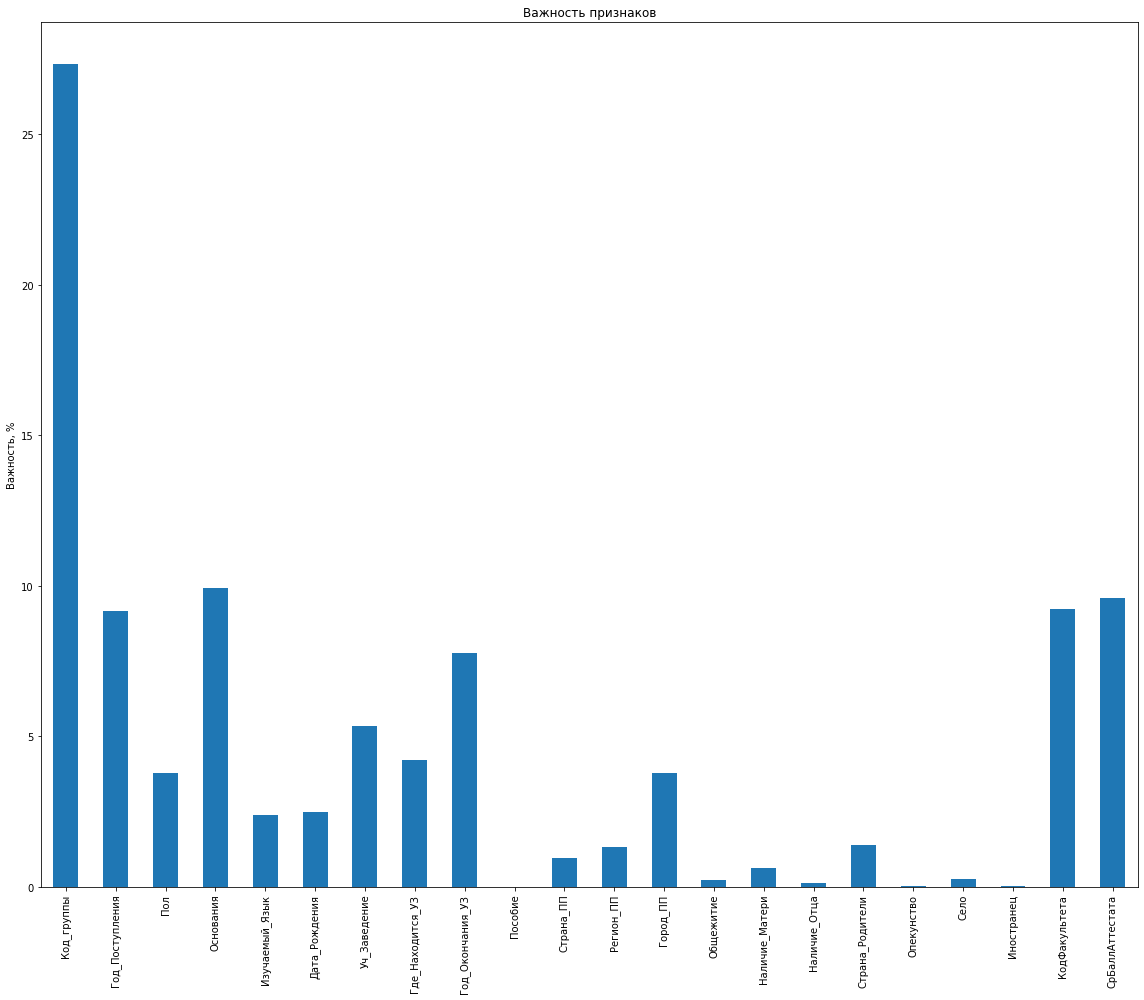

In [28]:
cat_iris_imp = pd.Series(model.get_feature_importance(),
                         df_test.drop(["Статус",'ID'], axis=1).columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Как видно, ряд признаков слабо влияют на модель. Создам список с признаками, где %>1 и 2

In [29]:
feat_imp = pd.Series(model.get_feature_importance(), df_test.drop(["Статус",'ID'], axis=1).columns)
feat_imp

Код_группы          27.347843
Год_Поступления      9.150685
Пол                  3.790656
Основания            9.938818
Изучаемый_Язык       2.373284
Дата_Рождения        2.489815
Уч_Заведение         5.360578
Где_Находится_УЗ     4.213483
Год_Окончания_УЗ     7.777485
Пособие              0.000000
Страна_ПП            0.955858
Регион_ПП            1.332851
Город_ПП             3.787696
Общежитие            0.236401
Наличие_Матери       0.614568
Наличие_Отца         0.123016
Страна_Родители      1.397407
Опекунство           0.017167
Село                 0.261265
Иностранец           0.024831
КодФакультета        9.222030
СрБаллАттестата      9.584262
dtype: float64

In [112]:
feat_imp_over1 = feat_imp[feat_imp>2].index
feat_imp_over1 = list(feat_imp_over1)

## Рассмотрим датасет по ближе

In [31]:
df = df_train.copy()

In [32]:
df.head(5)

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4
3,81661,19838,2017,Жен,БН,Английский язык,1994-12-08 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4
4,81509,19803,2017,Жен,БН,Английский язык,1995-06-28 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4


In [33]:
df.shape

(13584, 24)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13577 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    12758 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      12351 non-null  object 
 8   Где_Находится_УЗ  12203 non-null  object 
 9   Год_Окончания_УЗ  12284 non-null  float64
 10  Пособие           12576 non-null  float64
 11  Страна_ПП         13237 non-null  object 
 12  Регион_ПП         12966 non-null  object 
 13  Город_ПП          13141 non-null  object 
 14  Общежитие         13498 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_Отца      13584 non-null  float6

Псотрою тепловую карту пропущенных значений

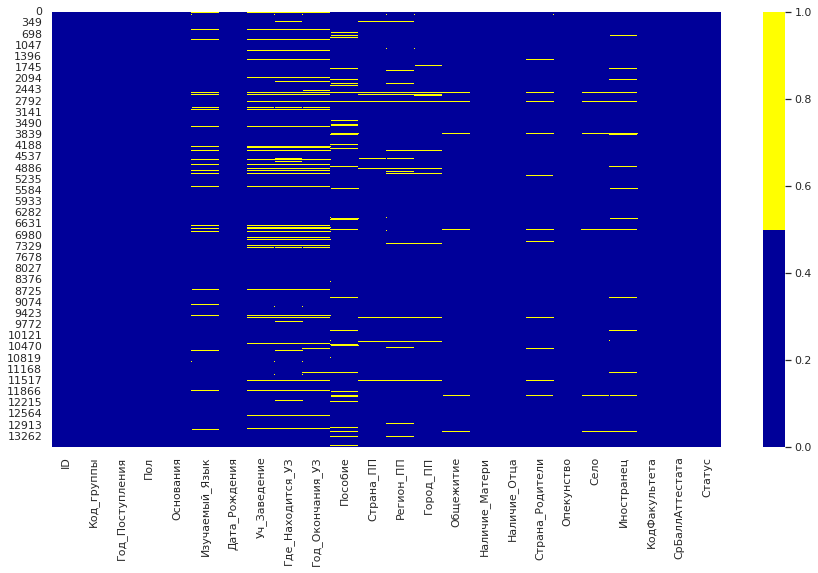

In [35]:
cols = df.columns
sns.set(rc = {'figure.figsize':(15,8)})
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [36]:
df['Пол'].isnull().sum()

7

Пропусков не много, часть из них заполним, часть уберем без потери качества датасета и будущей модели.

В признаке "пол" 7 пропусков. Удалим строки.

In [37]:
df = df.dropna(subset=['Пол'])

Изучу признаки на наличие аномалий и возможности их обработки.

In [38]:
df['Год_Поступления'].value_counts()

2015    2351
2014    2289
2016    2268
2013    2070
2017    1460
2012    1394
2018    1146
2019     466
2020      48
2011      46
2010      19
2009       8
2007       5
2008       2
2212       1
2001       1
2004       1
2005       1
2003       1
Name: Год_Поступления, dtype: int64

In [39]:
df['Год_Поступления'] = df['Год_Поступления'].replace(2212,2012)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
df['Пол'].value_counts()

Жен    8133
Муж    5443
муж       1
Name: Пол, dtype: int64

In [41]:
df['Пол'] = df['Пол'].replace('муж','Муж')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
df['Изучаемый_Язык'].value_counts()

Английский язык                  10444
Немецкий язык                     2219
Французский язык                    54
Русский язык                        11
Иностранный язык (Английский)       10
Англиийский                         10
Иностранный язык (Немецкий)          4
Name: Изучаемый_Язык, dtype: int64

In [43]:
def clean_lang(row):
  if 'Английский' in row:
    return 'Английский'
  elif 'Немецкий' in row:
    return 'Немецкий'
  elif 'Французский' in row:
    return 'Французский'
  elif 'Англиийский' in row:
    return 'Английский'
  elif 'no_info' in row:
    return 'no_info'
  else:
    return row

In [44]:
df['Изучаемый_Язык'] = df['Изучаемый_Язык'].fillna('no_info').apply(clean_lang)
df['Дата_Рождения'] = pd.to_datetime(df['Дата_Рождения'], format='%Y-%m-%d %H:%M:%S.%f')
df['возраст_поступления'] = (df['Год_Поступления'] - df['Дата_Рождения'].dt.year).astype('int')

In [45]:
df['Уч_Заведение'].value_counts().head(5)

ФГБОУ ВО Алтайский государственный университет                                   1359
ФГБОУ ВПО "Алтайский государственный университет"                                1025
ФГБОУ ВПО Алтайский государственный университет                                   113
ФГБОУ ВО Алтайский государственный технический университет им. И.И. Ползунова      88
Алтайский государственный университет                                              79
Name: Уч_Заведение, dtype: int64

Популярные вузы Алтайского края заполнены по разному. Создам функцию и приведу к единому виду.

In [46]:
def clean_school(row):
  if 'no_info' in row:
    return row
  elif 'Алтайский государственный университет' in row:
    return 'АлтГУ'
  elif 'Ползунова' in row:
    return 'АлтГТУ'
  else:
    return row


In [47]:
df['Уч_Заведение'] = df['Уч_Заведение'].fillna('no_info').astype('string')
df['Уч_Заведение'] = df['Уч_Заведение'].apply(clean_school)

In [48]:
df[df['Год_Окончания_УЗ']<df['Год_Поступления']].head(5)

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус,возраст_поступления
0,72716,16019,2015,Жен,ОО,Английский,1998-02-08,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3,17
15,84008,20889,2017,Жен,БН,Английский,1994-09-09,ФГКОУ ВО Академия Генеральной прокуратуры Росс...,Москва г,2016.0,...,1,1.0,Россия,0.0,1.0,0.0,26.0,70.000,4,23
19,65422,15423,2014,Жен,ОО,Английский,1990-07-30,АлтГУ,"Алтайский край, Барнаул г",2012.0,...,0,0.0,Россия,0.0,0.0,0.0,51.0,56.000,3,24
30,56807,15640,2013,Муж,СН,Немецкий,1988-01-21,"ФГВООУ ВПО ""Военный учебно-научный центр Сухо...",г. Москва,2012.0,...,0,0.0,Россия,0.0,0.0,NaN,45.0,65.000,3,25
35,63535,17818,2013,Жен,СН,Немецкий,1991-05-10,"КГОУ СПО ""Славгородский аграрный техникум""",город Славгород Алтайскогго края,2011.0,...,1,1.0,Россия,0.0,0.0,0.0,25.0,47.000,4,22


In [49]:
len(df[df['Год_Окончания_УЗ']<df['Год_Поступления']]) / len(df)

0.22405538778817116

В данных имеются записи с годом окончания вуза ранее ранее чем год поступления. доля таких данных в датасете - 23%. Возможна ошибка при заполнении данных - перепутаны местами даты. поменяю местами

In [50]:
df_tmp = df[['Год_Поступления','Год_Окончания_УЗ']]
df['Год_Поступления'], df['Год_Окончания_УЗ'] = df_tmp.min(axis=1), df_tmp.max(axis=1)
df['Год_Окончания_УЗ'] = df['Год_Окончания_УЗ'].astype('int')
df['Год_Поступления'] = df['Год_Поступления'].astype('int')
df['СрБаллАттестата'] = df['СрБаллАттестата'].astype('int')

In [51]:
df['Город_ПП'].value_counts().head(5)

Барнаул г        3734
г. Барнаул       1727
Барнаул          1174
Бийск г           246
Новоалтайск г     197
Name: Город_ПП, dtype: int64

Города ПП также вносились вручную, поэтому отличаются. Создам функцию, приведу к единому виду. Пропуск и аномальное значение - '  ', заменб на 'no_info'.

In [52]:
def clean_city(row):
  if 'no_info' in row:
    return row
  elif 'Барнаул' in row:
    return 'Барнаул'
  elif 'Бийск' in row:
    return 'Бийск'
  elif 'Новоалтайск' in row:
    return 'Новоалтайск'
  elif 'Камень-на-Оби' in row:
    return 'Камень-на-Оби'
  elif 'Рубцовск' in row:
    return 'Рубцовск'
  elif 'Горно-Алтайск' in row:
    return 'Горно-Алтайск'
  elif 'Славгород' in row:
    return 'Славгород'
  elif 'Семей' in row:
    return 'Семей'
  elif 'Москва' in row:
    return 'Москва'
  elif 'Заринск' in row:
    return 'Заринск'
  elif ' ' in row:
    return 'Заринск'
  else:
    return row

In [53]:
df['Город_ПП'] = df['Город_ПП'].fillna('no_info')
df['Город_ПП'] = df['Город_ПП'].apply(clean_city)

In [54]:
df['Где_Находится_УЗ'].value_counts().head(5)

Алтайский край, Барнаул г            2413
Алтайский край, г. Барнаул           1919
Россия, Алтайский край, г Барнаул    1264
Алтайский край, Бийск г               248
Алтайский край г. Барнаул             228
Name: Где_Находится_УЗ, dtype: int64

In [55]:
df['Где_Находится_УЗ'] = df['Где_Находится_УЗ'].fillna('no_info').apply(clean_city)

In [56]:
df['Регион_ПП'].value_counts().head(5)

Алтайский край                11491
Алтай Респ                      204
Республика Алтай                203
Восточно-Казахстанская обл      193
Кемеровская область              53
Name: Регион_ПП, dtype: int64

In [57]:
def clean_region(row):
  if 'no_info' in row:
    return row
  elif 'Алтай' in row:
    return 'Алтай'
  elif 'Восточно-Казахстанская' in row:
    return 'Восточно-Казахстанская обл'
  elif 'Кемеровская' in row:
    return 'Кемеровская обл'
  elif 'Новосибирская' in row:
    return 'Новосибирская обл'
  elif 'В-Казахстанская' in row:
    return 'Восточно-Казахстанская обл'
  elif 'Алайский' in row:
    return 'Алтай'
  elif 'Тыва' in row:
    return 'Республика Тыва'
  elif 'ВКО' in row:
    return 'Восточно-Казахстанская обл'
  elif 'Москва' in row:
    return 'Москва'
  elif 'Заринск' in row:
    return 'Заринск'
  else:
    return row

In [58]:
df['Регион_ПП'] = df['Регион_ПП'].fillna('no_info')
df['Регион_ПП'] = df['Регион_ПП'].apply(clean_region)

In [59]:
df['Город_ПП'].value_counts().head(5)

Барнаул        6865
Заринск        4121
Бийск           540
no_info         443
Новоалтайск     398
Name: Город_ПП, dtype: int64

In [60]:
df['Город_ПП'] = df['Город_ПП'].fillna('no_info').apply(clean_city)

In [61]:
df['Страна_Родители'].value_counts().head(5)

Россия         12239
Казахстан        513
Китай            142
Таджикистан      133
Кыргызстан        37
Name: Страна_Родители, dtype: int64

In [62]:
def clean_country(row):
  if 'no_info' in row:
    return row
  elif 'Кыргызстан' in row:
    return 'Киргизия'
  elif 'Кыргызская' in row:
    return 'Киргизия'
  elif 'Казахстан' in row:
    return 'Казахстан'
  elif 'казахстан' in row:
    return 'Казахстан'
  elif 'Таджикистан' in row:
    return 'Таджикистан'
  else:
    return row

In [63]:
df['Страна_Родители'] = df['Страна_Родители'].fillna('no_info').apply(clean_country)
df['срок_обучения'] = (df['Год_Окончания_УЗ'] - df['Год_Поступления']).astype('int')
df['Дата_Рождения'] = df['Дата_Рождения'].dt.year.astype('int')
df['КодФакультета'] = df['КодФакультета'].astype('int')

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение предсказываемой величены')

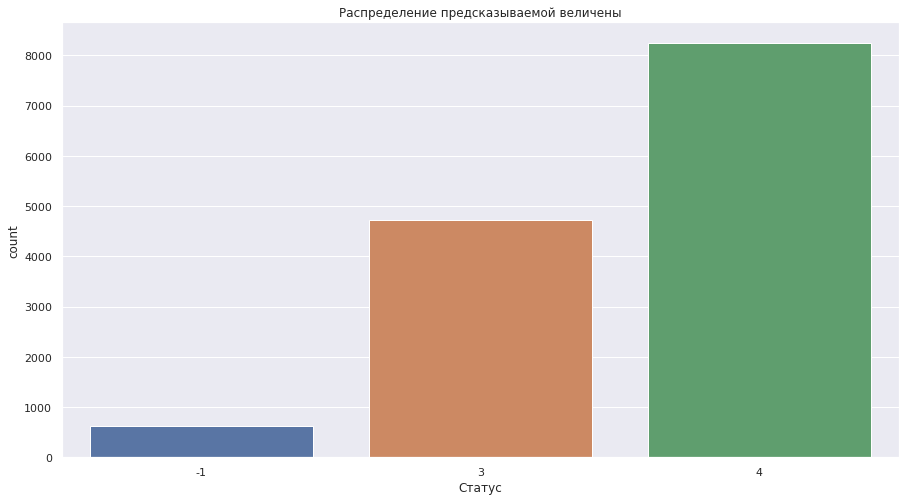

In [64]:
sns.countplot(x = "Статус" , data  = df).set_title('Распределение предсказываемой величены')

Text(0.5, 1.0, 'Распределение года поступления')

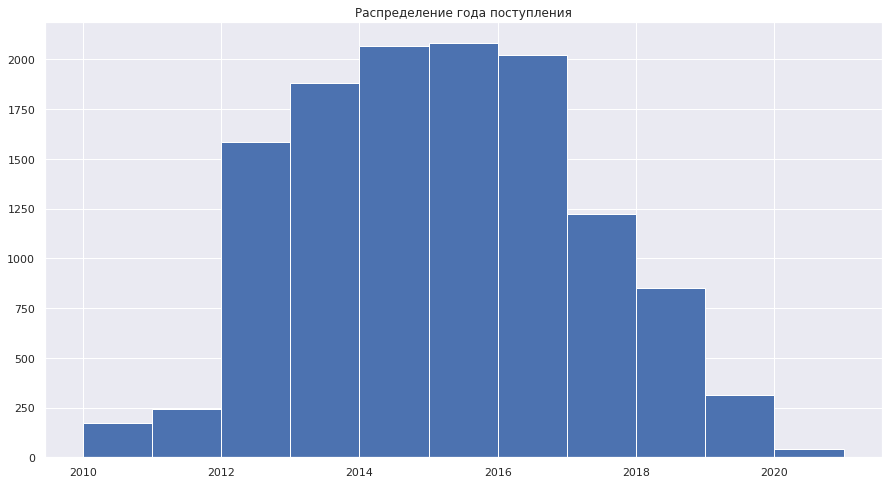

In [65]:
df["Год_Поступления"].hist(bins = 11, range = [2010, 2021]).set_title('Распределение года поступления')

Взглянем на несколько величин сразу

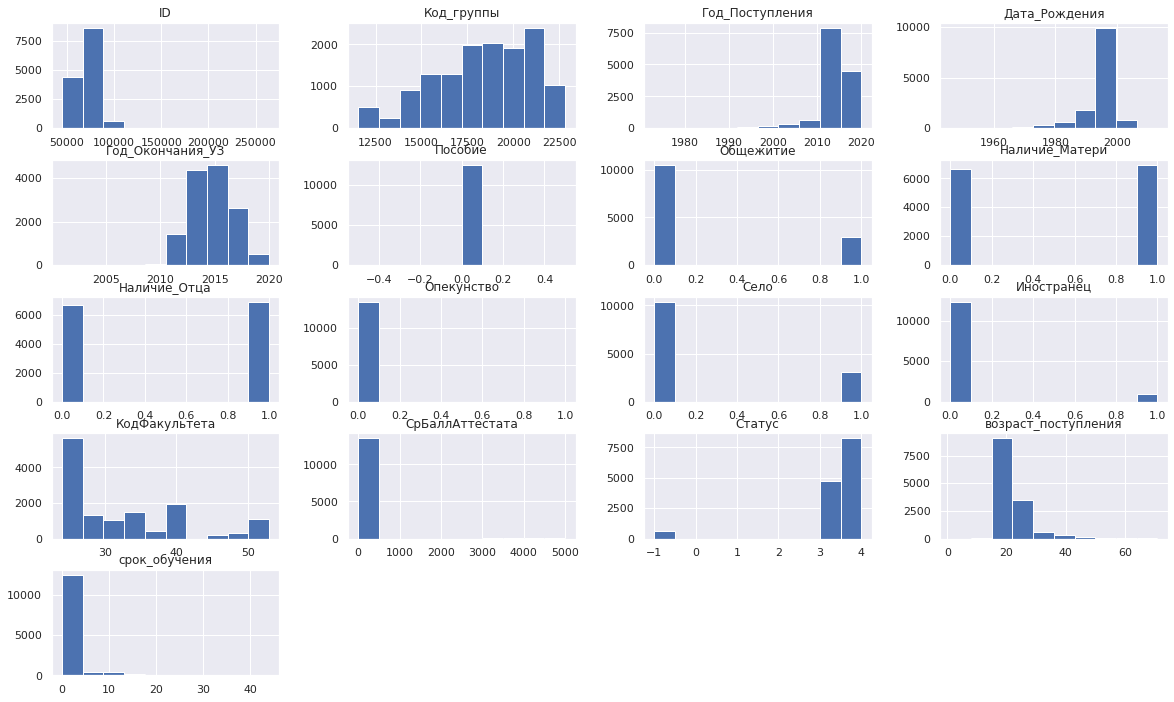

In [66]:
_ = df[df.columns].hist(figsize=(20,12))

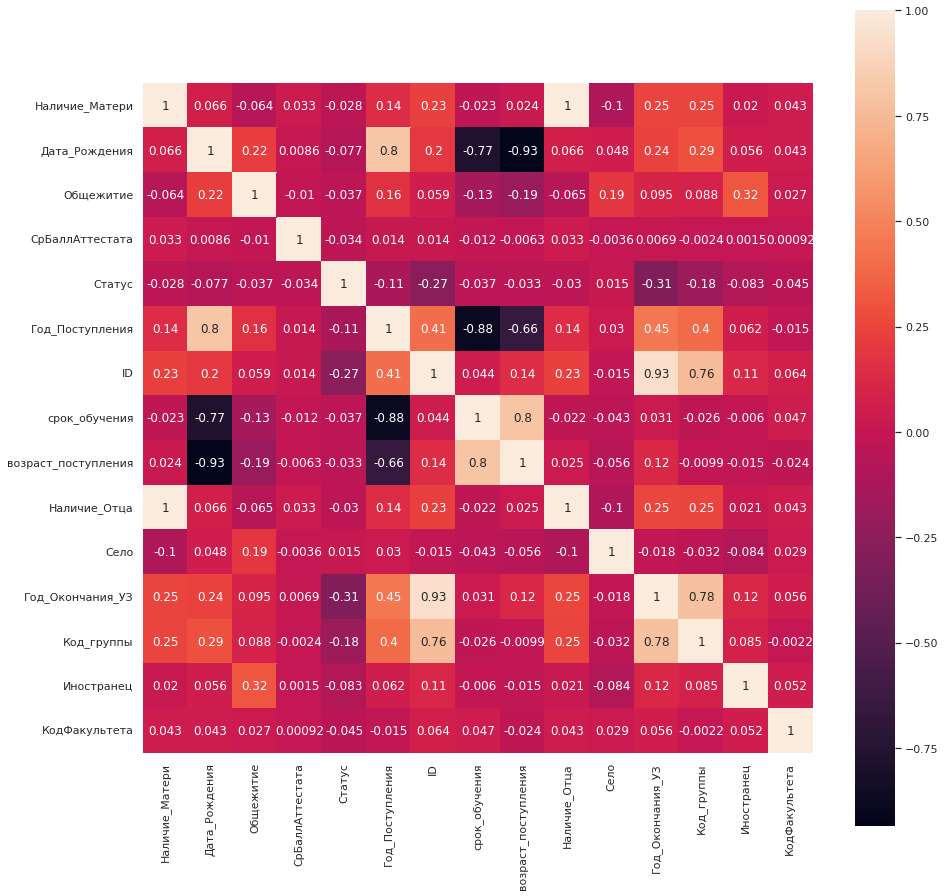

In [67]:
plt.rcParams['figure.figsize']=(15,15)


df_corr = list(set(df.columns.values) - set(['Опекунство','Пособие']))
g = sns.heatmap(df[df_corr].corr(), square = True, annot=True)

In [68]:
df['Пол'] = df['Пол'].astype('category').cat.codes
df['Изучаемый_Язык'] = df['Изучаемый_Язык'].astype('category').cat.codes
df['Основания'] = df['Основания'].astype('category').cat.codes
df['Страна_Родители'] = df['Страна_Родители'].astype('category').cat.codes


## Выделим выборки

In [93]:
feat_train = feat_imp_over1.append('Статус')

In [70]:
df = df[feat_train]

In [71]:
df[df.dtypes[df.dtypes == "object"].index.values] = df[df.dtypes[df.dtypes == "object"].index.values].astype('category')
mass_object = df.dtypes[df.dtypes == "category"].index.values

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [72]:
X_1 = df.drop(["Статус"], axis = 1)
y_1 = df[["Статус"]]
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.3, random_state=0)

## Обучение модели

In [73]:
model = CatBoostClassifier(loss_function='MultiClass',
                         depth = 4,iterations = 3000, learning_rate = 0.1, l2_leaf_reg = 10)
model.fit(X_train, y_train, cat_features = mass_object)

0:	learn: 1.0083911	total: 33.3ms	remaining: 1m 39s
1:	learn: 0.9395293	total: 58.8ms	remaining: 1m 28s
2:	learn: 0.8806083	total: 82.9ms	remaining: 1m 22s
3:	learn: 0.8301117	total: 114ms	remaining: 1m 25s
4:	learn: 0.7903959	total: 154ms	remaining: 1m 32s
5:	learn: 0.7565141	total: 179ms	remaining: 1m 29s
6:	learn: 0.7265920	total: 203ms	remaining: 1m 26s
7:	learn: 0.6997319	total: 228ms	remaining: 1m 25s
8:	learn: 0.6746213	total: 258ms	remaining: 1m 25s
9:	learn: 0.6569768	total: 282ms	remaining: 1m 24s
10:	learn: 0.6404938	total: 311ms	remaining: 1m 24s
11:	learn: 0.6247227	total: 336ms	remaining: 1m 23s
12:	learn: 0.6110014	total: 359ms	remaining: 1m 22s
13:	learn: 0.5968598	total: 384ms	remaining: 1m 21s
14:	learn: 0.5876813	total: 403ms	remaining: 1m 20s
15:	learn: 0.5762638	total: 427ms	remaining: 1m 19s
16:	learn: 0.5668862	total: 451ms	remaining: 1m 19s
17:	learn: 0.5555200	total: 480ms	remaining: 1m 19s
18:	learn: 0.5489685	total: 505ms	remaining: 1m 19s
19:	learn: 0.542567

## Оценка точности

In [74]:
pred_1 = model.predict(X_test)
f1_score(y_test, pred_1, average='macro', zero_division = 0)

0.7546246257470397

# Cоздание файла с ответом

In [117]:
def clean_test(df):
  df = df[feat_imp_over1]
  df['Изучаемый_Язык'] = df['Изучаемый_Язык'].fillna('no_info')
  df['Изучаемый_Язык'] = df['Изучаемый_Язык'].apply(clean_lang)
  df['Дата_Рождения'] = pd.to_datetime(df['Дата_Рождения'], format='%Y-%m-%d %H:%M:%S.%f')
  df['возраст_поступления'] = (df['Год_Поступления'] - df['Дата_Рождения'].dt.year).astype('int')
  df['Уч_Заведение'] = df['Уч_Заведение'].fillna('no_info').astype('string')
  df['Уч_Заведение'] = df['Уч_Заведение'].apply(clean_school)
  df_tmp = df[['Год_Поступления','Год_Окончания_УЗ']]
  df['Год_Поступления'], df['Год_Окончания_УЗ'] = df_tmp.min(axis=1), df_tmp.max(axis=1)
  df['Год_Окончания_УЗ'] = df['Год_Окончания_УЗ'].astype('int')
  df['Год_Поступления'] = df['Год_Поступления'].astype('int')
  df['СрБаллАттестата'] = df['СрБаллАттестата'].astype('int')
  df['Город_ПП'] = df['Город_ПП'].fillna('no_info')
  df['Город_ПП'] = df['Город_ПП'].apply(clean_city)
  df['Где_Находится_УЗ'] = df['Где_Находится_УЗ'].fillna('no_info').apply(clean_city)
  #df['Страна_Родители'] = df['Страна_Родители'].fillna('no_info').apply(clean_country)
  df['срок_обучения'] = (df['Год_Окончания_УЗ'] - df['Год_Поступления']).astype('int')
  df['Дата_Рождения'] = df['Дата_Рождения'].dt.year.astype('int')
  df['КодФакультета'] = df['КодФакультета'].astype('int')
  df['Пол'] = df['Пол'].astype('category').cat.codes
  df['Изучаемый_Язык'] = df['Изучаемый_Язык'].astype('category').cat.codes
  df['Основания'] = df['Основания'].astype('category').cat.codes
  #df['Страна_Родители'] = df['Страна_Родители'].astype('category').cat.codes
  return df

In [118]:
df_test = clean_test(df_test).fillna('no_info')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [120]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Код_группы           6691 non-null   int64 
 1   Год_Поступления      6691 non-null   int64 
 2   Пол                  6691 non-null   int8  
 3   Основания            6691 non-null   int8  
 4   Изучаемый_Язык       6691 non-null   int8  
 5   Дата_Рождения        6691 non-null   int64 
 6   Уч_Заведение         6691 non-null   object
 7   Где_Находится_УЗ     6691 non-null   object
 8   Год_Окончания_УЗ     6691 non-null   int64 
 9   Город_ПП             6691 non-null   object
 10  КодФакультета        6691 non-null   int64 
 11  СрБаллАттестата      6691 non-null   int64 
 12  возраст_поступления  6691 non-null   int64 
 13  срок_обучения        6691 non-null   int64 
dtypes: int64(8), int8(3), object(3)
memory usage: 594.7+ KB


In [122]:
mass_object = df_test.dtypes[df_test.dtypes == "object"].index.values
df_test[mass_object] = df_test[mass_object].astype('string')
df_test[mass_object] = df_test[mass_object].astype('category')

Провем те же манипуляции с данными что и на обучении

In [123]:
X = df.drop(["Статус"], axis = 1)
y = df[["Статус"]]
test = df_test

In [125]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13577 entries, 0 to 13583
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Код_группы        13577 non-null  int64   
 1   Год_Поступления   13577 non-null  int64   
 2   Пол               13577 non-null  int8    
 3   Основания         13577 non-null  int8    
 4   Изучаемый_Язык    13577 non-null  int8    
 5   Дата_Рождения     13577 non-null  int64   
 6   Уч_Заведение      13577 non-null  category
 7   Где_Находится_УЗ  13577 non-null  category
 8   Год_Окончания_УЗ  13577 non-null  int64   
 9   Регион_ПП         13577 non-null  category
 10  Город_ПП          13577 non-null  category
 11  Страна_Родители   13577 non-null  int8    
 12  КодФакультета     13577 non-null  int64   
 13  СрБаллАттестата   13577 non-null  int64   
dtypes: category(4), int64(6), int8(4)
memory usage: 1.5 MB


In [102]:
cat_mass = X.dtypes[X.dtypes == 'category'].index.values

In [103]:
model = CatBoostClassifier(loss_function='MultiClass')

In [ ]:
model.fit(X,y, cat_features = cat_mass)

In [105]:
df_test_pred = model.predict(test)

In [106]:
df_submission_2 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Altai/sample_submission.csv')

In [108]:
df_submission_2["Статус"] = df_test_pred
df_submission_2["Статус"] = df_submission_2["Статус"].astype('float')

In [109]:
df_submission_2.to_csv("/content/submission.csv", index= False)

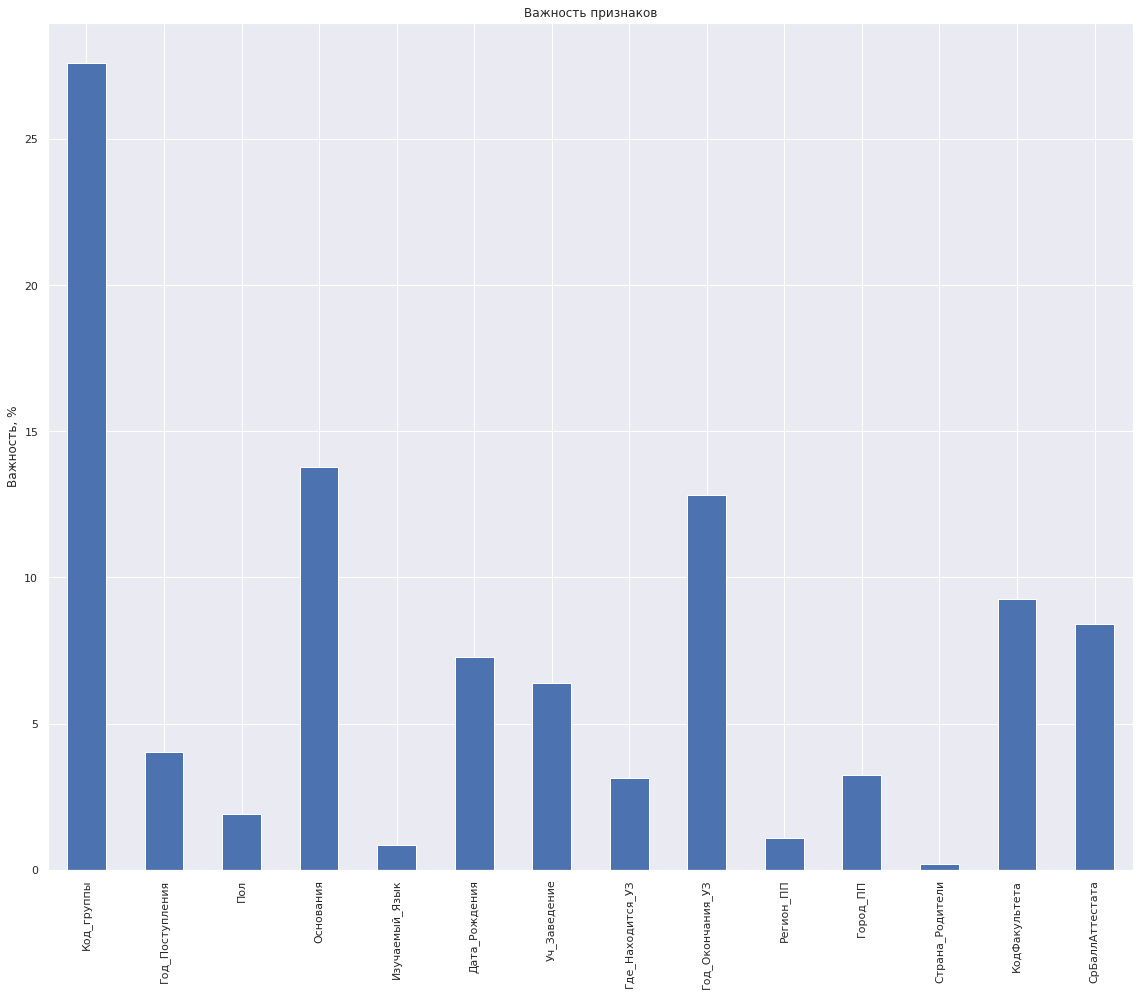

In [111]:
cat_iris_imp = pd.Series(model.get_feature_importance(),
                         X.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()